In [1]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/DRO-EDL/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.stats import norm, invgamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

/work/DRO-EDL/1d
['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/omnisafe/venv/lib/python3.10/site-packages', '__editable__.omnisafe-0.5.1.dev27+g080e6b8.finder.__path_hook__', '/home/omnisafe/venv/lib/python3.10/site-packages/pytorch_lightning-2.4.0-py3.10.egg', '/home/omnisafe/venv/lib/python3.10/site-packages/pandas-2.0.3-py3.10-linux-x86_64.egg']


input X: $(r,\theta)$

output Y: $(x, y)$

relationship: 
- $x = r\cdot sin(\theta)$
- $y = r\cdot cos(\theta)$

In [2]:
y_train

NameError: name 'y_train' is not defined

In [3]:
train_data = torch.concat([torch.linspace(-100, 100, 5000).unsqueeze(-1), torch.ones(5000).unsqueeze(-1)], axis=1)
def func(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arccos(x/r)
    return r , theta
# func(*train_data[0])
sigma = torch.normal(torch.zeros_like(train_data[:,0]), 0.1 * torch.ones_like(train_data[:,0])).unsqueeze(-1)

y_train = train_data[:,0].unsqueeze(-1) + sigma
y_train
x_train = torch.tensor([func(x,y) for x,y in train_data])

test_data = torch.concat([torch.linspace(-200, 200, 1000).unsqueeze(-1), 10*torch.ones(1000).unsqueeze(-1)], axis=1)
y_test = test_data[:,0].unsqueeze(-1)
y_test
x_test = torch.tensor([func(x,y) for x,y in test_data])

In [5]:
train_data.shape

torch.Size([5000, 2])

x_train: $r, \theta$

y_train: $x, y$

In [265]:
y_train[2500:2510], x_train[:,0][2500:2510] * np.cos(x_train[:,1][2500:2510])

(tensor([[0.1572],
         [0.1181],
         [0.0963],
         [0.0412],
         [0.0261],
         [0.0641],
         [0.3054],
         [0.2365],
         [0.2446],
         [0.4160]]),
 tensor([0.0200, 0.0600, 0.1000, 0.1400, 0.1800, 0.2200, 0.2601, 0.3001, 0.3401,
         0.3801]))

In [307]:
(x_train[:,0] * np.cos(x_train[:,1]) - y_train[:,0]).sum()

tensor(3.8937)

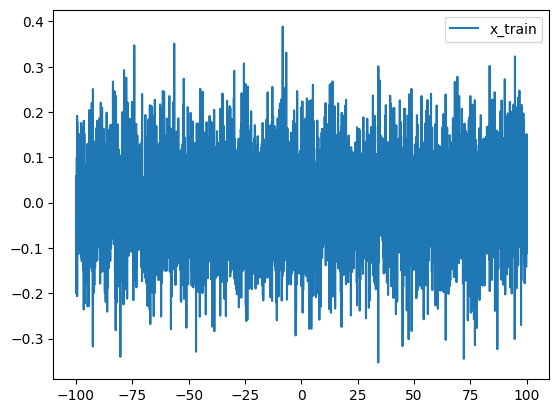

In [311]:
# plt.plot(*train_data.T, label='train data')
plt.plot( torch.linspace(-100, 100, 5000), x_train[:,0] * np.cos(x_train[:,1]) - y_train[:,0], label='x_train')
# plt.plot(x_train[:,0], torch.ones(5000), label='x_train (pseudo)')
# plt.plot(y_train[:,0], torch.ones(5000), label='y_train')
plt.legend()
# plt.ylim([0.99, 1.01])
plt.show()

In [217]:
def func2(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

func2(*func(3,4))

(0.029999999999999995, 0.04000000000000001)

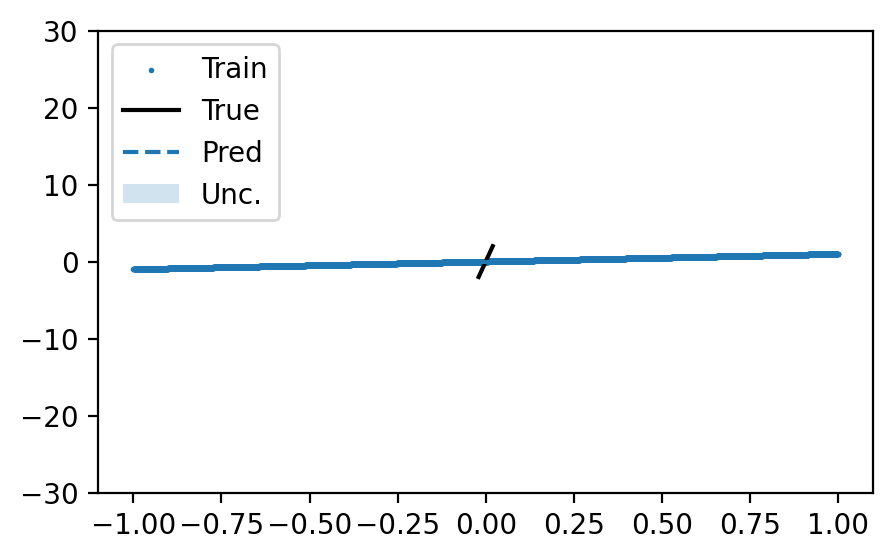

In [229]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from edl_pytorch import NormalInvGamma, evidential_regression

import numpy as np
import torch.optim as optim

torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
train_loss_list = list()
val_loss_list = list()
for epoch in range(2000):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        pred = model(x)
        loss = evidential_regression(pred, y, lamb=1e-2)
        if loss.isnan():
            print("nan!")
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_list.append(loss.detach().cpu())
    with torch.no_grad():
        pred = model(x_test)
        loss = evidential_regression(pred, y_test, lamb=1e-2)
        val_loss_list.append(loss.detach().cpu())

    torch.save(model.state_dict(), f'weights/{epoch}.pth')

with torch.no_grad():
    pred = model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
x_test = x_test.squeeze()
var = torch.sqrt(beta / (v * (alpha - 1)))

# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=200)
x_train_data = [func2(x,y)[0] for x,y in x_train]
x_test_data = [func2(x,y)[0] for x,y in x_test]
plt.scatter(x_train_data, y_train, s=1.0, c="tab:blue", label="Train")
plt.plot(x_test_data, y_test, c="k", label="True")
plt.plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test_data,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-30, 30)
# plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()

In [236]:
x_test_data

[tensor(-0.0200),
 tensor(-0.0200),
 tensor(-0.0199),
 tensor(-0.0199),
 tensor(-0.0198),
 tensor(-0.0198),
 tensor(-0.0198),
 tensor(-0.0197),
 tensor(-0.0197),
 tensor(-0.0196),
 tensor(-0.0196),
 tensor(-0.0196),
 tensor(-0.0195),
 tensor(-0.0195),
 tensor(-0.0194),
 tensor(-0.0194),
 tensor(-0.0194),
 tensor(-0.0193),
 tensor(-0.0193),
 tensor(-0.0192),
 tensor(-0.0192),
 tensor(-0.0192),
 tensor(-0.0191),
 tensor(-0.0191),
 tensor(-0.0190),
 tensor(-0.0190),
 tensor(-0.0190),
 tensor(-0.0189),
 tensor(-0.0189),
 tensor(-0.0188),
 tensor(-0.0188),
 tensor(-0.0188),
 tensor(-0.0187),
 tensor(-0.0187),
 tensor(-0.0186),
 tensor(-0.0186),
 tensor(-0.0186),
 tensor(-0.0185),
 tensor(-0.0185),
 tensor(-0.0184),
 tensor(-0.0184),
 tensor(-0.0184),
 tensor(-0.0183),
 tensor(-0.0183),
 tensor(-0.0182),
 tensor(-0.0182),
 tensor(-0.0182),
 tensor(-0.0181),
 tensor(-0.0181),
 tensor(-0.0180),
 tensor(-0.0180),
 tensor(-0.0180),
 tensor(-0.0179),
 tensor(-0.0179),
 tensor(-0.0178),
 tensor(-0

In [235]:
fig, ax = plt.subplots(figsize=(5,3), dpi=200)
# plt.figure(figsize=(5, 3), dpi=200)

for epoch in range(100):
    clear_output(wait=True)  # 이전 그림을 지웁니다
    ax.clear()
    model.load_state_dict(torch.load(f'weights/{epoch*10}.pth'))
    with torch.no_grad():
        pred = model(x_test)
    
    mu, v, alpha, beta = (d.squeeze() for d in pred)
    x_test = x_test.squeeze()
    var = torch.sqrt(beta / (v * (alpha - 1)))
    
    # plot code modified from
    # https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
    x_train_data = [func2(x,y)[0] for x,y in x_train]
    x_test_data = [func2(x,y)[0] for x,y in x_test]
    ax.scatter(x_train_data, y_train, s=1.0, c="tab:blue", label="Train")
    ax.plot(x_test_data, y_test, c="k", label="True")
    ax.plot(x_test_data, mu * 100, c="tab:blue", ls="--", label="Pred")
    for std in range(4):
        ax.fill_between(
            x_test_data,
            (mu - std * var),
            (mu + std * var),
            alpha=0.2,
            facecolor="tab:blue",
            label="Unc." if std == 0 else None,
        )
    ax.set_ylim(-100, 100)
    # plt.gca().set_xlim(-7, 7)
    ax.legend(loc="upper left")
    ax.set_title(f'epoch: {epoch*10}')
    display(fig)  # 새 그림을 표시합니다
plt.close(fig)  # 루프가 끝난 후 그림을 닫습니다

KeyboardInterrupt: 

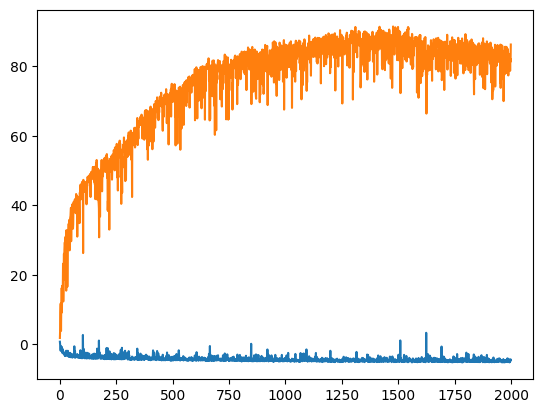

In [230]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.show()

[10.04987562112089, 3.0419240010986313]
[-9.764516] [0.6132949] [5.103151] [0.04783896]
[0.01901056]


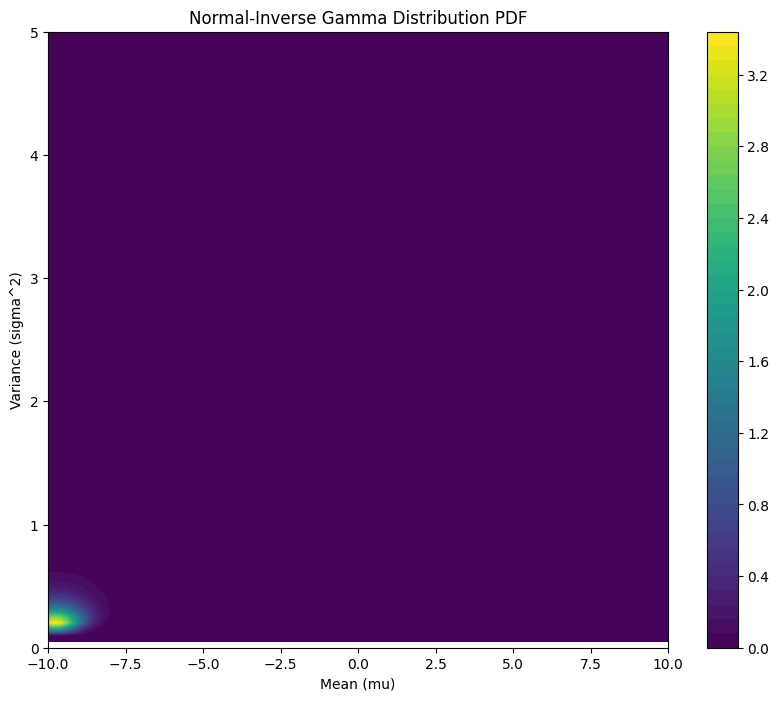

[5.0990195135927845, 2.9441970937399127]
[-4.987023] [2.4633834] [5.5366645] [0.02156848]
[0.00192997]


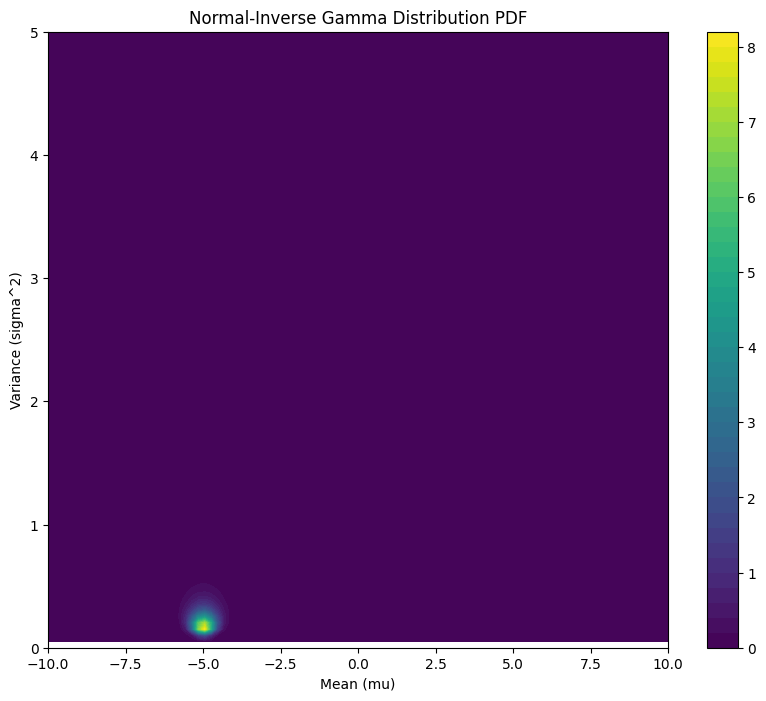

[5.0990195135927845, 0.19739555984988041]
[1.6914926] [0.05253753] [1.8449323] [0.8704617]
[19.60912]


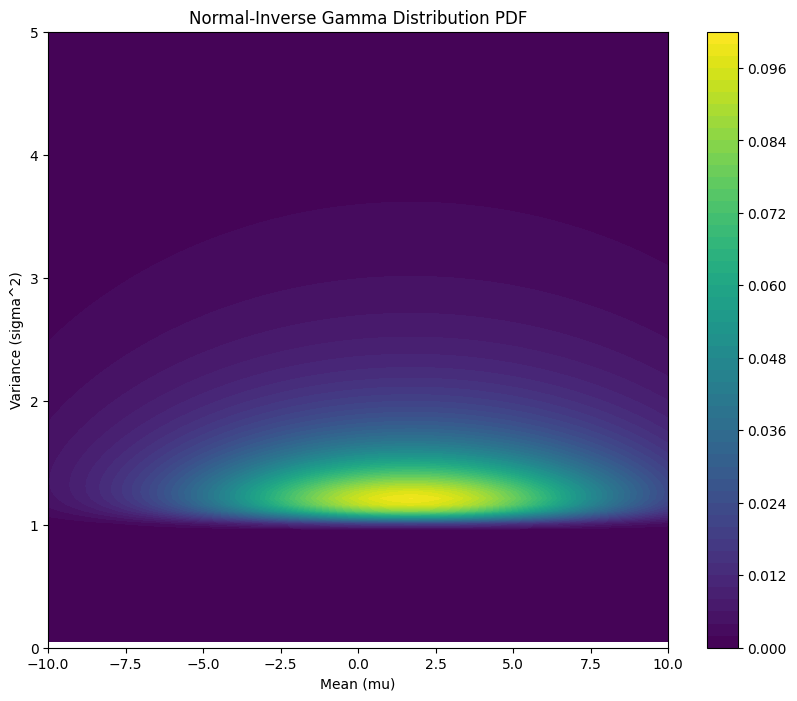

[10.04987562112089, 0.09966865249116184]
[1.4653944] [0.00513088] [1.933253] [0.95659035]
[199.77199]


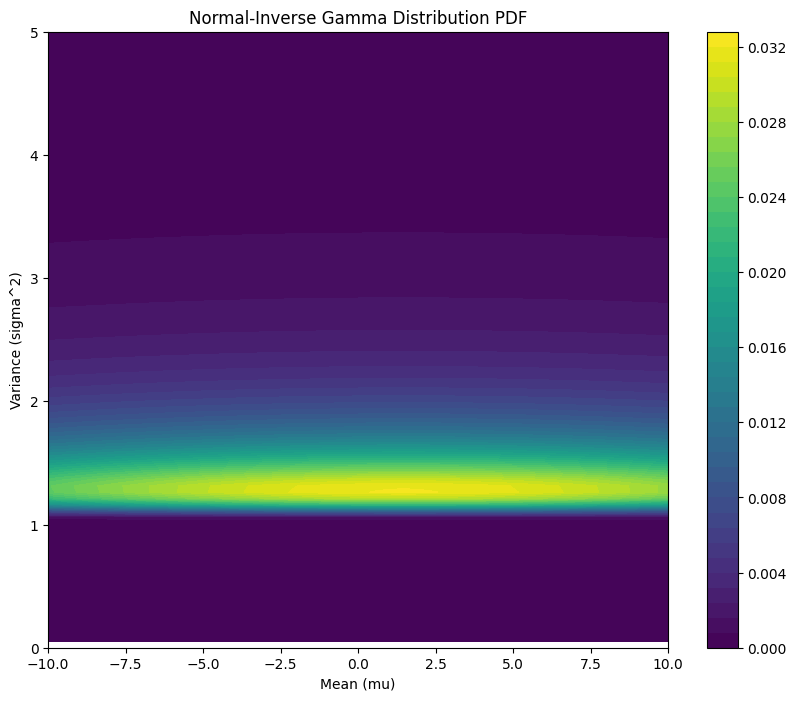

In [38]:
data = [-10., -5., 5., 10.]
for d in data:
    input = [float(x) for x in func(d,1.)]
    print(input)
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor(input))]
    print(mu_0, lambda_, alpha, beta)
    print(beta / ((alpha-1)*lambda_))
    # Define parameters for the Normal-Inverse Gamma distribution
    # mu_0 = 0  # Prior mean
    # lambda_ = 1  # Scale parameter
    # alpha = 2  # Shape parameter
    # beta = 2  # Scale parameter
    
    # Create a grid for mean (mu) and variance (sigma^2)
    mu = np.linspace(-10, 10, 100)
    sigma2 = np.linspace(0., 5, 100)
    mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)
    
    # Compute the probability density function values for the Normal-Inverse Gamma distribution
    pdf_values = np.zeros_like(mu_grid)
    
    for i in range(mu_grid.shape[0]):
        for j in range(mu_grid.shape[1]):
            mu_val = mu_grid[i, j]
            sigma2_val = sigma2_grid[i, j]
            # Normal-Inverse Gamma PDF (up to proportionality constant)
            # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
            #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
            pdf_values[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

    
    # Plot the PDF values
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('Mean (mu)')
    plt.ylabel('Variance (sigma^2)')
    plt.title('Normal-Inverse Gamma Distribution PDF')
    plt.show()

[-4.987023] [2.4633834] [5.5366645] [0.02156848]
E[mu]:  [-4.987023]
Var[mu]:  [0.00192997]
E[sigma]:  [0.00475426]
E[sigma] / lambda:  [0.00192997]
diff min:  2.2683820373482604
[0.03437821] [0.6471334]
msv:  0.30294526

[0.08105826] [1.9407282] [3.693709] [0.11131461]
E[mu]:  [0.08105826]
Var[mu]:  [0.021293]
E[sigma]:  [0.04132392]
E[sigma] / lambda:  [0.021293]
diff min:  4.048934861920081
[0.09696241] [5.880345]
msv:  0.4921549

[1.6113046] [0.381835] [2.2193615] [0.524747]
E[mu]:  [1.6113046]
Var[mu]:  [1.1270462]
E[sigma]:  [0.4303457]
E[sigma] / lambda:  [1.1270462]
diff min:  14.491109702346815
[1.5515891] [70.0924]
msv:  1.7901479



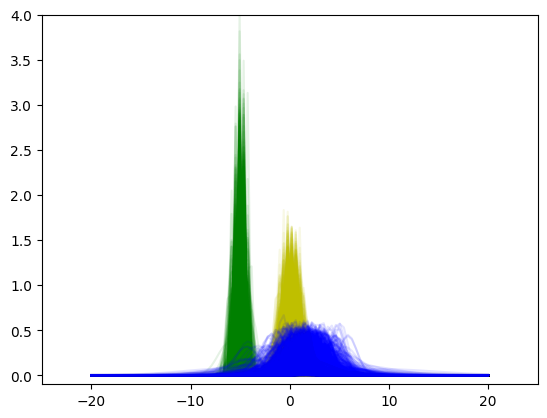

In [46]:
dist_colors = ['g', 'y', 'b']
for i,d in enumerate([-5., 0., 2.]):
    input = [float(x) for x in func(d,1.)]
    mu_0, lambda_, alpha, beta = [x.detach().numpy() for x in model(torch.tensor(input))]
    print(mu_0, lambda_, alpha, beta)
    print("E[mu]: ",mu_0)
    print("Var[mu]: ",(beta / ((alpha-1)*lambda_)))
    print("E[sigma]: ",(beta / (alpha-1)))
    print("E[sigma] / lambda: ",(beta / (alpha-1)) / lambda_)
    
    num_dist_samples = 1000
    l = np.linspace(-20, 20, 100)
    mu_list = list()
    sigma_list = list()
    msv_list = list()
    for _ in range(num_dist_samples):
        sigma2_sample = invgamma.rvs(alpha, beta)
        mu_sample = norm.rvs(mu_0, np.sqrt(sigma2_sample / lambda_))
        msv_list.append(np.sqrt(sigma2_sample / lambda_))
        mu_list.append(mu_sample)
        sigma_list.append(sigma2_sample / lambda_)
        plt.plot(l, norm.pdf(l, mu_sample, sigma2_sample), alpha=0.1, color=dist_colors[i])
    print("diff min: ",max(mu_list) - min(mu_list))
    print(min(sigma_list), max(sigma_list))
    print("msv: ",np.array(msv_list).mean())
    plt.xlim(-25,25)
    plt.ylim(-0.1,4)
    print()
    
plt.show()

1.6914926 0.05253753 1.8449323 0.8704617
opt result:    message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.10008582303191142
        x: [ 1.691e+00  1.206e+00]
      nit: 15
      jac: [-1.388e-08  1.507e-06]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
1.6914898397984963 1.2055916506767042
Mode PDF:  0.10008582303191142
0.0


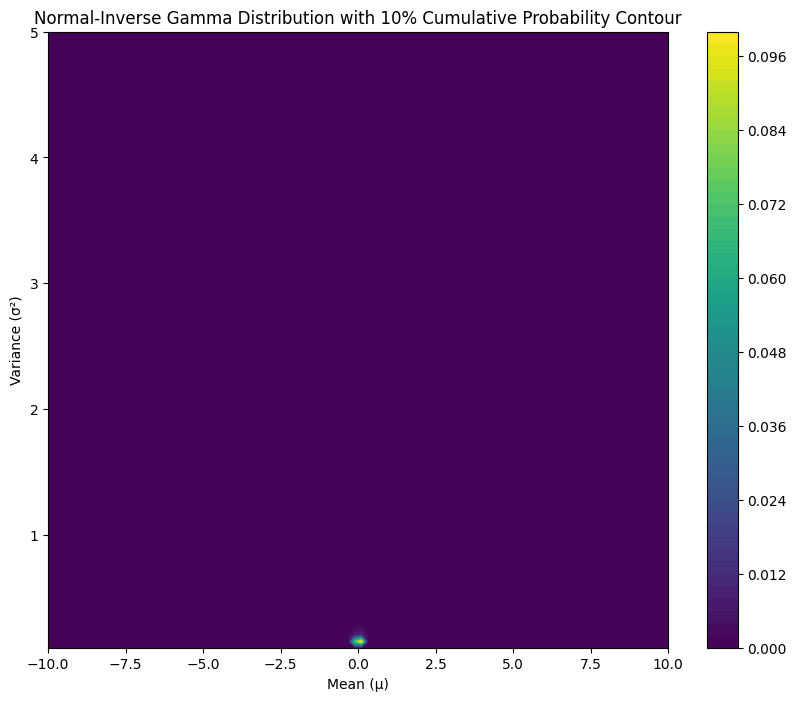

In [4]:


# Parameters for NIG distribution
mu0 = 0
kappa = 1
alpha = 3
beta = 2

mu_0, lambda_, alpha, beta = 0,1,3,2

mu_0, lambda_, alpha, beta = 1.6914926, 0.05253753, 1.8449323, 0.8704617#1.4653944, 0.00513088, 1.933253, 0.95659035

print(mu_0, lambda_, alpha, beta)
# Define parameters for the Normal-Inverse Gamma distribution
# mu_0 = 0  # Prior mean
# lambda_ = 1  # Scale parameter
# alpha = 2  # Shape parameter
# beta = 2  # Scale parameter

# Create a grid for mean (mu) and variance (sigma^2)
mu = np.linspace(-10, 10, 100)
sigma2 = np.linspace(0.1, 5, 100)
mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)

# Compute the probability density function values for the Normal-Inverse Gamma distribution
pdf_values = np.zeros_like(mu_grid)

for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        mu_val = mu_grid[i, j]
        sigma2_val = sigma2_grid[i, j]
        # Normal-Inverse Gamma PDF (up to proportionality constant)
        # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
        #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
        pdf_values[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))


# Plot the PDF values
plt.figure(figsize=(10, 8))
cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
plt.colorbar(cp)



# Normal-Inverse Gamma PDF
def normal_inverse_gamma_pdf(mu, sigma2, mu0, lambda_, alpha, beta):
    # coeff = np.sqrt(kappa / (2 * np.pi * sigma2))
    # prior_mu = np.exp(-kappa * (mu - mu0) ** 2 / (2 * sigma2))
    # prior_sigma2 = beta ** alpha / gamma(alpha) * (sigma2 ** (-alpha - 1)) * np.exp(-beta / sigma2)
    # return coeff * prior_mu * prior_sigma2
    return invgamma.pdf(sigma2, alpha, beta) * norm.pdf(mu, mu_0, np.sqrt(sigma2 / lambda_))

    
# Define the range for integration
mu_range = (-10, 10)
sigma2_range = (0.01, 5)

# Find the mode (most probable point) of the NIG distribution
def neg_pdf(params):
    mu, sigma2 = params
    return -normal_inverse_gamma_pdf(mu, sigma2, mu0, lambda_, alpha, beta)

initial_guess = [0, 1]
result = minimize(neg_pdf, initial_guess, bounds=[mu_range, sigma2_range])
print("opt result: ",result)
mode_mu, mode_sigma2 = result.x
print(mode_mu, mode_sigma2)

# Define the cumulative probability function
def cumulative_probability(mu, sigma2, mu0, lambda_, alpha, beta, mode_pdf, threshold):
    def integrand(m, s2):
        return normal_inverse_gamma_pdf(m, s2, mu0, lambda_, alpha, beta)
    
    def integrand_normalized(m, s2):
        return integrand(m, s2) / mode_pdf
    
    integral, error = dblquad(integrand_normalized, sigma2_range[0], sigma2, lambda _: mu_range[0], lambda _: mu)
    return integral - threshold

# Find the contour level for 10% cumulative probability
mode_pdf = normal_inverse_gamma_pdf(mode_mu, mode_sigma2, mu0, lambda_, alpha, beta)
print('Mode PDF: ', mode_pdf)
threshold = 0.9

def find_contour_level():
    
    def objective(c):
        return (cumulative_probability(mode_mu, mode_sigma2, mu0, lambda_, alpha, beta, mode_pdf, c) - threshold)**2
    result = minimize(objective, mode_pdf-0.1, bounds=[(0, mode_pdf)])
    return result.x[0]

contour_level = find_contour_level()
print(contour_level)
# Generate the contour plot
mu_vals = np.linspace(-1000, 1000, 100)
sigma2_vals = np.linspace(0.1, 500, 100)
MU, SIGMA2 = np.meshgrid(mu_vals, sigma2_vals)
# pdf_vals = normal_inverse_gamma_pdf(MU, SIGMA2, mu0, kappa, alpha, beta)


pdf_vals = np.zeros_like(MU)

for i in range(MU.shape[0]):
    for j in range(SIGMA2.shape[1]):
        mu_val = MU[i, j]
        sigma2_val = SIGMA2[i, j]
        # Normal-Inverse Gamma PDF (up to proportionality constant)
        # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
        #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
        
        pdf_vals[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

# cp = plt.contour(MU, SIGMA2, pdf_vals, levels=[contour_level], colors='red')

cp = plt.contourf(mu, sigma2, pdf_vals, levels=50, cmap='viridis')
plt.xlabel('Mean (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Normal-Inverse Gamma Distribution with 10% Cumulative Probability Contour')
plt.show()


TypeError: Length of x (100) must match number of columns in z (1000)

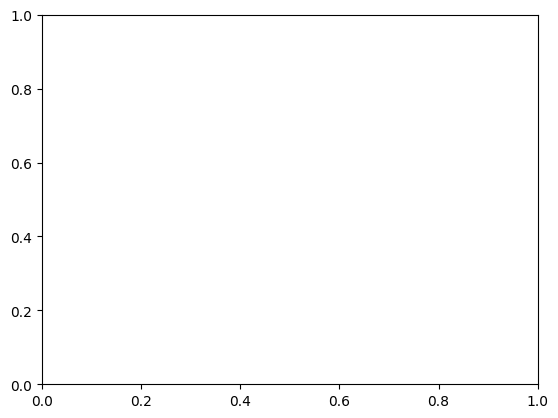

In [149]:
mu_vals = np.linspace(-100, 100, 1000)
sigma2_vals = np.linspace(0.1, 500, 1000)
MU, SIGMA2 = np.meshgrid(mu_vals, sigma2_vals)

pdf_vals = np.zeros_like(MU)

for i in range(MU.shape[0]):
    for j in range(SIGMA2.shape[1]):
        mu_val = MU[i, j]
        sigma2_val = SIGMA2[i, j]
        # Normal-Inverse Gamma PDF (up to proportionality constant)
        # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
        #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
        
        pdf_vals[i, j] = invgamma.pdf(sigma2_val, alpha, beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

# cp = plt.contour(MU, SIGMA2, pdf_vals, levels=[contour_level], colors='red')

cp = plt.contourf(mu, sigma2, pdf_vals, levels=50, cmap='viridis')
plt.xlabel('Mean (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Normal-Inverse Gamma Distribution with 10% Cumulative Probability Contour')
plt.show()

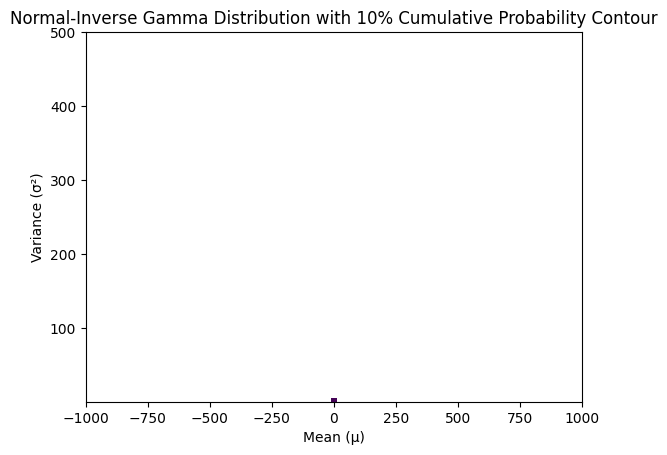

In [143]:
cp = plt.contourf(mu, sigma2, pdf_vals, levels=50, cmap='viridis')
cp = plt.contour(MU, SIGMA2, pdf_vals, levels=[0.02733968894740313], colors='red')
plt.xlabel('Mean (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Normal-Inverse Gamma Distribution with 10% Cumulative Probability Contour')
plt.show()

In [108]:
normal_inverse_gamma_pdf(1.69, 1.20, mu0, kappa, alpha, beta)

0.43646230972550065

In [113]:
invgamma.pdf(1.20, alpha, beta) * norm.pdf(1.69, mu_0, np.sqrt(sigma2_val / lambda_))

0.0490103259666262

In [150]:
p_l = pdf_vals.flatten()
p_l.sort()
p_l[int(len(p_l) * 0.9)]

2.4299328005176364e-08

In [6]:
from scipy.integrate import dblquad

# Define the density function of the Normal-Inverse-Gamma distribution
def normal_inverse_gamma_pdf(mu, sigma2, mu_0, lambda_, alpha, beta):
    normal_part = norm.pdf(mu, mu_0, np.sqrt(sigma2 / lambda_))
    invgamma_part = invgamma.pdf(sigma2, alpha, scale=beta)
    return normal_part * invgamma_part

# Define the integration function that restricts to density >= c
def integrand(mu, sigma2, mu_0, lambda_, alpha, beta, c):
    density = normal_inverse_gamma_pdf(mu, sigma2, mu_0, lambda_, alpha, beta)
    return density if density >= c else 0

# Perform the dblquad integration
c = 0.001  # Assume this is the density threshold for 90%
mu_range = (-5, 5)          # Range for mu (set according to the distribution's support)
sigma2_range = (0.01, 10)   # Range for sigma^2 (positive values only)

volume, error = dblquad(integrand, *mu_range, lambda x: sigma2_range[0], lambda x: sigma2_range[1],
                        args=(mu_0, lambda_, alpha, beta, c))

/tmp/ipykernel_1493/319446629.py:5: RuntimeWarning: invalid value encountered in sqrt
  normal_part = norm.pdf(mu, mu_0, np.sqrt(sigma2 / lambda_))
/home/omnisafe/venv/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [8]:
error

2.110997825947506e-06

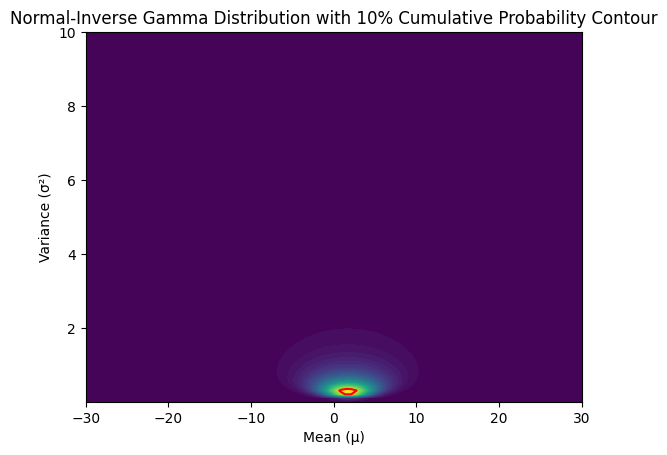

In [135]:
mu_0, lambda_, alpha, beta = 1.6914926, 0.05253753, 1.8449323, 0.8704617#1.4653944, 0.00513088, 1.933253, 0.95659035


# Create a grid for mean (mu) and variance (sigma^2)
mu_s, mu_e, mu_n = -30, 30, 100
sigma2_s, sigma2_e, sigma2_n = 0.001, 10., 100
mu = np.linspace(mu_s, mu_e, mu_n)
sigma2 = np.linspace(sigma2_s, sigma2_e, sigma2_n)
mu_grid, sigma2_grid = np.meshgrid(mu, sigma2)


dmu = (mu_e - mu_s) / mu_n
dsigma2 = (sigma2_e - sigma2_s) / sigma2_n
dA = dmu * dsigma2

# Compute the probability density function values for the Normal-Inverse Gamma distribution
pdf_values = np.zeros_like(mu_grid)

for i in range(mu_grid.shape[0]):
    for j in range(mu_grid.shape[1]):
        mu_val = mu_grid[i, j]
        sigma2_val = sigma2_grid[i, j]
        # Normal-Inverse Gamma PDF (up to proportionality constant)
        # pdf_values[i, j] = (sigma2_val ** (-alpha - 1)) * np.exp(-beta / sigma2_val) * \
        #                    norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))
        pdf_values[i, j] = invgamma.pdf(sigma2_val, alpha, scale=beta) * norm.pdf(mu_val, mu_0, np.sqrt(sigma2_val / lambda_))

cp = plt.contourf(mu, sigma2, pdf_values, levels=50, cmap='viridis')
cp = plt.contour(mu, sigma2, pdf_values, levels=[0.20831899984381083], colors='red')

plt.xlabel('Mean (μ)')
plt.ylabel('Variance (σ²)')
plt.title('Normal-Inverse Gamma Distribution with 10% Cumulative Probability Contour')
plt.show()

In [83]:
dA

0.059994000000000006

In [134]:
pl = pdf_values.flatten()
pl.sort()
cl = pl.cumsum() * dA
pl[np.where(cl > 0.9)[0][0]]

0.20831899984381083

In [91]:
pl[9987]

0.08638683400401746

In [148]:
import numpy as np
from scipy.stats import invgamma
from scipy.optimize import fsolve

# 임의의 파라미터 설정
alpha = 3.0  # shape parameter
beta = 2.0   # scale parameter
target_pdf_value = 0.5  # target PDF value

# 정의된 PDF 함수에서 목표 값을 만족하는 x를 찾는 함수 정의
def equation(x):
    return invgamma.pdf(x, alpha, scale=beta) - target_pdf_value

# small
# 초기 추정값 설정 후 방정식 해결
initial_guess = 0.4
solution = fsolve(equation, initial_guess)[0]
print("small: ",solution)

# large
# 초기 추정값 설정 후 방정식 해결
initial_guess = 5.0
solution = fsolve(equation, initial_guess)[0]
print("large: ",solution)


small:  0.2775024471331411
large:  1.039740501511389


In [ ]:
ㅑㅜ

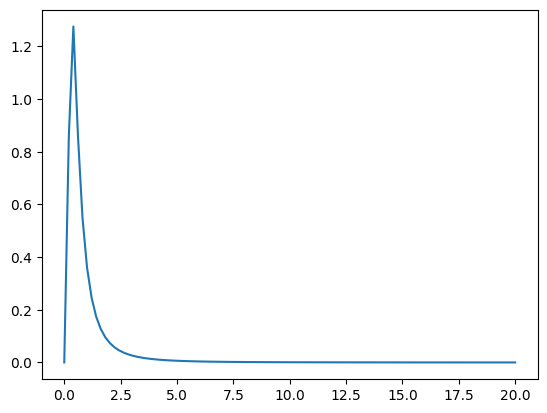

0.0


In [124]:
l = np.linspace(0, 20, 100)
plt.plot(l, invgamma.pdf(l, 2,scale=1))
plt.show()
print(invgamma.pdf(0.8519741161722452,2,1))

In [149]:
calculated_pdf_value = invgamma.pdf(0.277, alpha, scale=beta)
calculated_pdf_value

0.4970964764098091